# In-class exercise week 4: Tracing dynamic similarity between quality and fake news sources

One may wonder to what extent fake news sources follow the agenda of quality news outlets. In this assignment, we try to map the overlap in articles (i.e., agenda convergence) published by Infowars, an extreme right/ fake news source, and BBC and The Guardian on the other hand--which are generally considered high quality news sources.

specifically, in this notebook, we will use and compare two methods of similarity: `cosine` and `soft-cosine`. 

You can find, and download, the full dataset here:
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/ULHLCB

Please that this dataset is rather large, and we do not need all this data for practice purposes. You can download a random sample of the data from Canvas, under week 4 (`articles.zip`) 

<br>

<div class="alert-warning">
Please run the code step by step and make sure you follow what is happening. If you do not understand the code, ask your tutorial teacher or fellow students for help.
</div>

### Reading in the data

In [4]:

PATH = '/Users/anne/repos/CCS-2/week04/resources/articles'

#PATH = 'resources/articles'

from glob import glob
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from dateutil import parser
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

In [38]:
RANDOM_N=2000 # set a random number, of max 2000 (if you work with the smaller datafile). 
#you can also set this value to 20 or so, just for the purpose of practice--and speeding up the code

def read_data(listofoutlets, RANDOM_N):
    date = []
    title = []
    outlets = []
    texts = []
    for outlet in listofoutlets:
        
        for file in random.choices(glob(f'{PATH}/*/{outlet}/*'), k=RANDOM_N):
            date.append(file.split('--')[-2])
            title.append(file.split('--')[-1])
            with open(file) as f:
                texts.append(f.read())
                outlets.append(outlet)
    return date, title, texts, outlets

dates, title, texts, outlets = read_data(['Infowars', 'BBC', 'The Guardian'], RANDOM_N)

In [53]:
dates_formatted = [parser.parse(e).strftime("%Y-%b") for e in dates]
dates_formatted[0:4]

['2018-Sep', '2018-Feb', '2018-Nov', '2018-Jul']


<u>Question 1</u> 

 <br>

<div class="alert-info">
Can you understand the code above? Why are we formatting the date variable?  <br>
Check the type of data you are working with, print the first entry of each list, perform some sanity checks.
</div>

    An example of a sanity check if for example to check whether all the lists are of equal length (which you would expect here)
```python

assert len(dates) == len(title) == len(texts) == len(outlets)# example sanity checks
```


### Initialize a time frame

Ultimatly, we would like to have observations (i.e., cosine similarity scores) for each month in the period 2018. It might be, however, that we cannot calculate values for each month (incase we have missings). To avoid ending up with missing months in our dataframe, we create this list before the start of our analysis.

In [18]:
lists_of_dates = pd.date_range('2018-01-01','2019-01-01', freq='MS').strftime("%Y-%b").tolist()

# 1. Dynamic Agenda overlap with Cosine Similarity 
We use`sklearn`'s`cosine_similarity` to calculate cosine similarity scores

### Vectorize the data

In [6]:
vec = CountVectorizer(stop_words='english')
count_matrix = vec.fit(texts) # fit on all the data
transformed_text = vec.transform(texts)

<u>Question 2</u> 
<br>
<br>
<div class="alert-info">
Can you improve the code in the cell above? <br>
e.g., use pruning rather than stopword removal, or tranform the data using the tfidf algorithm.
</div>


### Utility function: Create list of tuples, for each of the outlets. 

In [54]:
combined = list(zip(dates_formatted, title, texts, outlets, transformed_text))

infowars = [e for e in combined if e[3]=='Infowars']
bbc = [e for e in combined if e[3]=='BBC']
guardian = [e for e in combined if e[3]=='The Guardian']

NameError: name 'transformed_text' is not defined

### Calcuting Cosine Similarity scores across outlets overtime

The next utility function will calculate cosine similarity scores between two agendas, in chuncks of months. More specifically, for each month of our selected time frame, we will calculate cosine similarity scores between articles from a fake news source on the one hand (`infowars`), and a quality news source on the other (`BBC`)

In [17]:
def get_cosine_overtime(source1, source2, list_of_dates):
    
    '''calculate cosine similarity sources between articles nested within months'''

    time_frame = []
    monthly_cosine_similarity = []
    number_of_combinations = []

    for month in tqdm(lists_of_dates):
        
        all_combinations = []

        source1_comparison = [i for i in source1 if i[0]==month]
        source2_comparison = [i for i in source2 if i[0]==month]

        for i in source1_comparison:
            single_combinations = []
            for e in source2_comparison:
                
                assert month == i[0] == e[0] #sanity check
                
                sim_score = cosine_similarity(i[4], e[4])
                single_combinations.append(sim_score[0][0])

            all_combinations.extend(single_combinations)

        time_frame.append(month)
        monthly_cosine_similarity.append(np.mean(all_combinations))
        number_of_combinations.append(len(all_combinations))
    return [time_frame, monthly_cosine_similarity, number_of_combinations]


In [18]:
results_guardian_bbc = get_cosine_overtime(guardian, bbc, lists_of_dates)

  0%|          | 0/13 [00:00<?, ?it/s]/Users/anne/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anne/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 13/13 [05:50<00:00, 27.00s/it]


In [20]:
results_guardian_infowars = get_cosine_overtime(guardian, infowars, lists_of_dates)

  0%|          | 0/13 [00:00<?, ?it/s]/Users/anne/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anne/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 13/13 [05:54<00:00, 27.30s/it]


In [23]:
results_bbc_infowars = get_cosine_overtime(bbc, infowars, lists_of_dates)

100%|██████████| 13/13 [05:46<00:00, 26.62s/it]


### Convert meta data to a dataframe
To inspect the data, and maybe visualize it, it might be nice to convert it to a tabular format. 

In [31]:
def get_meta_dataframe(combined_data):
    df = pd.DataFrame(combined)
    df.columns = ['date', 'title', 'text', 'outlet', 'vectorized']

    df['Infowars'] = np.where(df['outlet'] == 'Infowars', 1,0)
    df['BBC'] = np.where(df['outlet'] == 'BBC', 1,0)
    df['The Guardian'] = np.where(df['outlet'] == 'The Guardian', 1,0)

    # aggregate the dataframe on the level of months, with number of articles within outlets in the rows:
    df = df.groupby('date')[['Infowars', 'BBC', 'The Guardian']].sum()
    
    return df

df = get_meta_dataframe(combined)
df.head()

,Infowars,BBC,The Guardian
date,,,
2018-Apr,0,4,1
2018-Aug,1,2,3
2018-Feb,4,0,1
2018-Jul,1,2,2
2018-Jun,2,1,2


### Create a df with the cosine similairy scores between two agendas

In [32]:
def get_cosine_frame(results, source1, source2):
    cosine = pd.DataFrame(results).T
    cosine.rename(columns={0: 'date', 1:f'cosine_{source1}_{source2}', 2: f'combinations_{source1}_{source2}'},inplace=True)
    cosine = cosine.set_index('date')
    return cosine

cosine_guardian_bbc = get_cosine_frame(results_guardian_bbc,'guardian', 'bbc')
cosine_guardian_infowars = get_cosine_frame(results_guardian_infowars,'guardian', 'infowars')
cosine_bbc_infowars = get_cosine_frame(results_bbc_infowars,'bbc', 'infowars')

In [33]:
df = pd.merge(cosine_guardian_bbc, df, left_index=True, right_index=True, how='inner')
df = pd.merge(cosine_guardian_infowars, df, left_index=True, right_index=True, how = 'inner')
df = pd.merge(cosine_bbc_infowars, df, left_index=True, right_index=True, how = 'inner')

In [34]:
df

,cosine_bbc_infowars,combinations_bbc_infowars,cosine_guardian_infowars,combinations_guardian_infowars,cosine_guardian_bbc,combinations_guardian_bbc,Infowars,BBC,The Guardian
date,,,,,,,,,
2018-Feb,0.036769,26344,0.079578,30082,0.052883,25012,178,148,169
2018-Mar,0.038497,49750,0.074006,42750,0.062238,34029,250,199,171
2018-Apr,0.041426,34595,0.084854,31603,0.060646,31265,187,185,169
2018-May,0.03696,35588,0.084213,26568,0.068221,35154,164,217,162
2018-Jun,0.043636,21924,0.092049,19278,0.069261,11832,189,116,102
2018-Jul,0.041129,57456,0.087611,32400,0.077019,39900,216,266,150
2018-Aug,0.03798,48600,0.084175,44325,0.057958,42552,225,216,197
2018-Sep,0.038229,33099,0.072665,34408,0.063116,32568,187,177,184
2018-Oct,0.041149,50481,0.077045,70503,0.067104,78447,213,237,331


<u>Question 3</u> 
<br>
<br>
<div class="alert-info">
Inspect the results. Where do you see the highest overlap? Which agendas have the highest overlap? Does Infowars follow the agenda of The Guardian or the BBC more closely?<br>
Is this what you expected?
</div>


<u>Question 4</u> 
<br>
<br>
<div class="alert-info">
Adjust the code, e.g., by changing the vectorizer, and inspect the effects thereof in the final results.<br>
Is this more in line with what you would expect? 
</div>


### Visualize 

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(9,7)})
sns.set_style("white")

Before we can draw a lineplot, we need to change the dataframe from a wide to a long format. That what we will do next. 

In [36]:
df.index = pd.to_datetime(df.index)
df = df.reset_index()

long = pd.melt(df, id_vars = 'date', value_vars = ['cosine_guardian_infowars', 'cosine_guardian_bbc', 'cosine_bbc_infowars'], var_name='agendas', value_name='cosine_similarity')
long["cosine_similarity"] = pd.to_numeric(long["cosine_similarity"], downcast="float")

<AxesSubplot:xlabel='date', ylabel='cosine_similarity'>

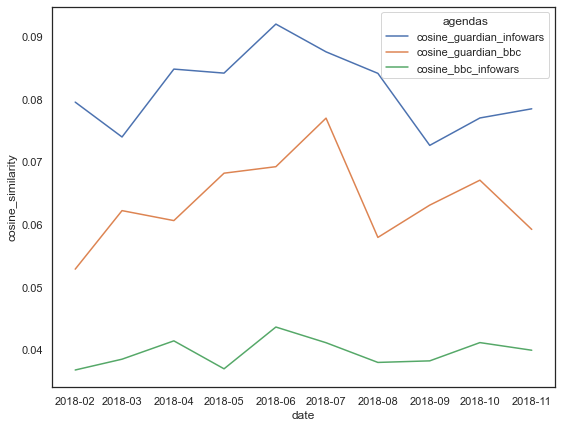

In [37]:
sns.lineplot(x='date', y='cosine_similarity', hue='agendas', data=long)

You may wonder how overlap relates to absolute attention (=number of articles published within months within the outlets). We can plot both simultaneously in one graph.

<AxesSubplot:xlabel='date', ylabel='attention'>

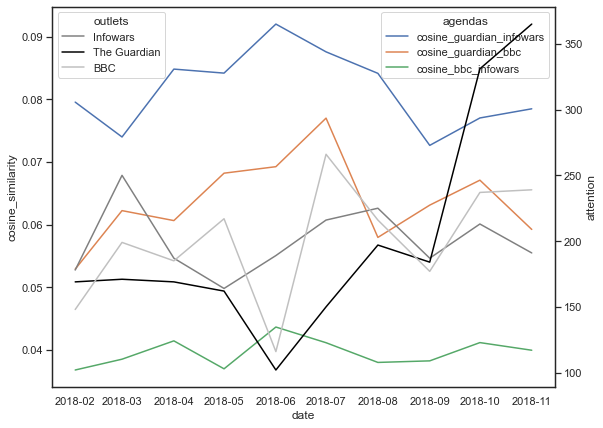

In [38]:
long_attention = pd.melt(df, id_vars = 'date', value_vars = ['Infowars', 'The Guardian', 'BBC'], var_name='outlets', value_name='attention')

sns.lineplot(x='date', y='cosine_similarity', hue='agendas', data=long)
ax2 = plt.twinx()
sns.lineplot(x='date',y='attention', hue='outlets', palette=['grey', 'black', 'silver'], data=long_attention, ax=ax2)

<u>Question 5</u> 
<br>
<br>
<div class="alert-info">
Does this make sense? Can you see a (reverse) relation between absolute attention and cosine scores?
</div>


# 2. Dynamic Agenda overlap with Soft-Cosine Similarity 
Here, we will use `gensim`

In [73]:
import gensim
from gensim import corpora
import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel
from gensim.similarities import SparseTermSimilarityMatrix
from gensim.similarities import WordEmbeddingSimilarityIndex
print(gensim.__version__)

from gensim.corpora import Dictionary
import numpy as np

4.1.2


In [75]:
print(f"Your gensim version is {gensim.__version__}. This notebook assumes that you have version 4.0 or higher. If not, please upgrade.")
assert int(gensim.__version__[0])>=4

Your gensim version is 4.1.2. This notebook assumes that you have version 4.0 or higher. If not, please upgrade.


### Load the model...
<br>
<div class="alert-danger">
Please note that the next block may take a while to run...
</div>

In [2]:
fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')

In [39]:
dictionary = corpora.Dictionary([simple_preprocess(doc) for doc in texts]) #initialize a Dictionary

<div class="alert-danger">
Please note that the next block may take a while to run...
</div>

In [40]:
similarity_index = WordEmbeddingSimilarityIndex(fasttext_model300)
similarity_matrix = SparseTermSimilarityMatrix(similarity_index, dictionary) # Build a term similarity matrix and compute the Soft Cosine Measure.

100%|██████████| 47536/47536 [28:33<00:00, 27.75it/s]


In [41]:
bag_of_words_vectors = [ dictionary.doc2bow(simple_preprocess(doc)) for doc in texts]

In [56]:
combined = list(zip(dates_formatted, title, texts, outlets, bag_of_words_vectors))

infowars = [e for e in combined if e[3]=='Infowars']
bbc = [e for e in combined if e[3]=='BBC']
guardian = [e for e in combined if e[3]=='The Guardian']

In [43]:
#similarity_matrix.inner_product(infowars[0][4], infowars[1][4], normalized=(True, True))

Please check the data...

e.g.,by printing **parts** of the lists, using list slicing;

```python
bbc[0]
```

In [60]:
def get_soft_cosine_overtime(source1, source2, lists_of_dates):

    '''Adjusted function, estimates the soft cosine similarity'''
    
    time_frame = []
    monthly_cosine_similarity = []
    number_of_combinations = []

    for month in tqdm(lists_of_dates):
        
        all_combinations = []

        source1_comparison = [i for i in source1 if i[0]==month]
        source2_comparison = [i for i in source2 if i[0]==month]

        for i in source1_comparison:
            
            single_combinations = []
            for e in source2_comparison:
                
                assert month == i[0] == e[0] #sanity check
                
                sim_score = similarity_matrix.inner_product(i[4], e[4], normalized=(True, True))
                single_combinations.append(sim_score)

            all_combinations.extend(single_combinations)

        time_frame.append(month)
        monthly_cosine_similarity.append(np.mean(all_combinations))
        number_of_combinations.append(len(all_combinations))
    return [time_frame, monthly_cosine_similarity, number_of_combinations]

<u>Question 6</u> 
<br>
<br>
<div class="alert-info">
Can you tell where this function differs? Where is the soft cosine (rather than the regular cosine) calculated?
</div>


In [61]:
results_guardian_infowars = get_soft_cosine_overtime(guardian, infowars, lists_of_dates)

  0%|          | 0/13 [00:00<?, ?it/s]/Users/anne/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anne/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 13/13 [08:28<00:00, 39.14s/it]


In [62]:
results_guardian_bbc = get_soft_cosine_overtime(guardian, bbc, lists_of_dates)

100%|██████████| 13/13 [10:02<00:00, 46.38s/it]


In [63]:
results_bbc_infowars = get_soft_cosine_overtime(bbc, infowars, lists_of_dates)

100%|██████████| 13/13 [06:34<00:00, 30.36s/it]


### Get data in `df` object

In [64]:
df = get_meta_dataframe(combined)
df

,Infowars,BBC,The Guardian
date,,,
2018-Apr,174,165,164
2018-Aug,215,230,195
2018-Feb,179,160,150
2018-Jul,197,241,202
2018-Jun,180,100,98
2018-Mar,237,204,169
2018-May,189,228,173
2018-Nov,193,248,326
2018-Oct,224,228,329


In [65]:
def get_soft_cosine_frame(results, source1, source2):
    cosine = pd.DataFrame(results).T
    cosine.rename(columns={0: 'date', 1:f'soft_cosine_{source1}_{source2}', 2: f'combinations_{source1}_{source2}'},inplace=True)
    cosine = cosine.set_index('date')
    return cosine

soft_cosine_guardian_bbc = get_soft_cosine_frame(results_guardian_bbc,'guardian', 'bbc')
soft_cosine_guardian_infowars = get_soft_cosine_frame(results_guardian_infowars,'guardian', 'infowars')
soft_cosine_bbc_infowars = get_soft_cosine_frame(results_bbc_infowars,'bbc', 'infowars')

In [66]:
df = pd.merge(soft_cosine_guardian_bbc, df, left_index=True, right_index=True, how='inner')
df = pd.merge(soft_cosine_guardian_infowars, df, left_index=True, right_index=True, how='inner')
df = pd.merge(soft_cosine_bbc_infowars, df, left_index=True, right_index=True, how='inner')

In [67]:
df

,soft_cosine_bbc_infowars,combinations_bbc_infowars,soft_cosine_guardian_infowars,combinations_guardian_infowars,soft_cosine_guardian_bbc,combinations_guardian_bbc,Infowars,BBC,The Guardian
date,,,,,,,,,
2018-Feb,0.735943,28640,0.778744,26850,0.78812,24000,179,160,150
2018-Mar,0.718231,48348,0.768993,40053,0.808582,34476,237,204,169
2018-Apr,0.702663,28710,0.759614,28536,0.782632,27060,174,165,164
2018-May,0.706873,43092,0.76946,32697,0.797442,39444,189,228,173
2018-Jun,0.746886,18000,0.790015,17640,0.804048,9800,180,100,98
2018-Jul,0.718287,47477,0.753146,39794,0.803093,48682,197,241,202
2018-Aug,0.722035,49450,0.773085,41925,0.797372,44850,215,230,195
2018-Sep,0.702326,41552,0.734388,41128,0.777236,38024,212,196,194
2018-Oct,0.727864,51072,0.761457,73696,0.814269,75012,224,228,329


### visualize

In [70]:
df.index = pd.to_datetime(df.index)
df = df.reset_index()
long = pd.melt(df, id_vars = 'date', value_vars = ['soft_cosine_guardian_infowars','soft_cosine_guardian_bbc', 'soft_cosine_bbc_infowars'], var_name='Outlets', value_name='Soft Cosine Similarity')

<AxesSubplot:xlabel='date', ylabel='Soft Cosine Similarity'>

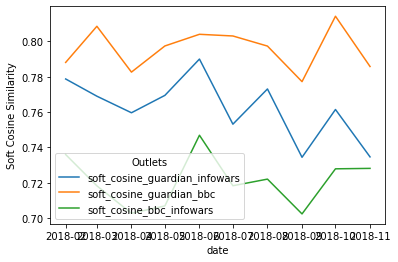

In [71]:
long["Soft Cosine Similarity"] = pd.to_numeric(long["Soft Cosine Similarity"], downcast="float")
sns.lineplot(x='date', y='Soft Cosine Similarity', hue='Outlets', data=long)


<u>Question 7</u> 
<br>
<br>
<div class="alert-info">
Compare these findings to regular cosine findings. Are you suprised by the difference in these findings? What strikes you most?
</div>
